In [1]:
import pandas as pd


In [4]:
df=pd.read_csv('../data/raw/bank/bank-full.csv',sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


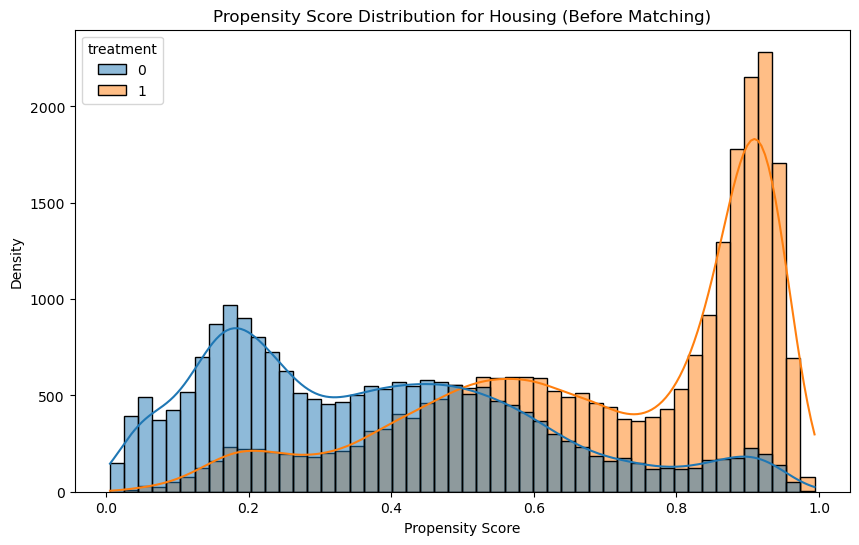

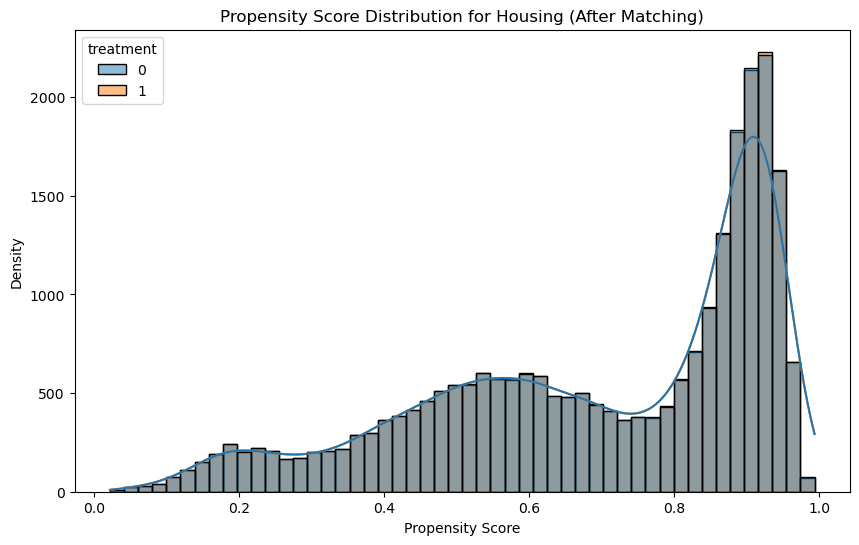

  housing  treatment  propensity_score_housing
0     yes          1                  0.838482
1     yes          1                  0.869967
2     yes          1                  0.938883
3     yes          1                  0.890517
5     yes          1                  0.920024


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load dataset (Assuming it's already loaded as df)
# df = pd.read_csv("your_dataset.csv")

# ✅ Step 1: Define Treatment Variable (Housing Loan: 1 if Yes, 0 if No)
df['treatment'] = (df['housing'] == 'yes').astype(int)  

# ✅ Step 2: Define Covariates (excluding target 'y' and treatment 'housing')
X = df.drop(columns=['y', 'treatment', 'housing'], errors='ignore')  # Remove housing to prevent leakage

# Convert categorical variables to dummies
X = pd.get_dummies(X, drop_first=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Step 3: Compute Propensity Scores using Logistic Regression
logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(X_scaled, df['treatment'])
df['propensity_score_housing'] = logreg.predict_proba(X_scaled)[:, 1]

# ✅ Step 4: Perform Nearest Neighbors Matching
treated = df[df['treatment'] == 1].copy()
control = df[df['treatment'] == 0].copy()

# Fit NearestNeighbors model on control group propensity scores
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score_housing']])

# Find the nearest match for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score_housing']])

# Get matched control samples
matched_control = control.iloc[indices.flatten()].copy()

# Create the balanced dataset
balanced_df = pd.concat([treated, matched_control])

# ✅ Step 5: Visualize Propensity Score Distributions (Before & After Matching)
plt.figure(figsize=(10, 6))
sns.histplot(df, x='propensity_score_housing', hue='treatment', bins=50, kde=True)
plt.title("Propensity Score Distribution for Housing (Before Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(balanced_df, x='propensity_score_housing', hue='treatment', bins=50, kde=True)
plt.title("Propensity Score Distribution for Housing (After Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.show()

# ✅ Step 6: Display First Few Rows
print(balanced_df[['housing', 'treatment', 'propensity_score_housing']].head())


In [7]:
# Ensure 'treatment' is an integer (0 or 1)
df['treatment'] = pd.to_numeric(df['treatment'], errors='coerce').astype(int)

# Ensure 'propensity_score_housing' is a float
df['propensity_score_housing'] = pd.to_numeric(df['propensity_score_housing'], errors='coerce')

# Ensure 'y' is numeric (convert 'yes'/'no' to 1/0 if necessary)
if df['y'].dtype == 'object':  
    df['y'] = df['y'].map({'yes': 1, 'no': 0})  # Convert categorical target to binary numeric

# Drop rows where 'propensity_score_housing' is NaN after conversion
df = df.dropna(subset=['propensity_score_housing'])

# Compute inverse probability weights
df['weights'] = df['treatment'] / df['propensity_score_housing'] + \
                (1 - df['treatment']) / (1 - df['propensity_score_housing'])

# Trim excessive weights (99th percentile)
weight_threshold = df['weights'].quantile(0.99)
df_trimmed = df[df['weights'] <= weight_threshold]

# Compute ATE using weighted regression
ATE_weighted = (df_trimmed['y'] * df_trimmed['treatment'] / df_trimmed['propensity_score_housing']).mean() - \
               (df_trimmed['y'] * (1 - df_trimmed['treatment']) / (1 - df_trimmed['propensity_score_housing'])).mean()

print("ATE (Effect of Housing Loan on Subscription Likelihood):", ATE_weighted)


ATE (Effect of Housing Loan on Subscription Likelihood): -0.044018962517886326


In [8]:
# Compute inverse probability weights
df['weights'] = df['treatment'] / df['propensity_score_housing'] + \
                (1 - df['treatment']) / (1 - df['propensity_score_housing'])

# Trim excessive weights (99th percentile)
weight_threshold = df['weights'].quantile(0.99)
df_trimmed = df[df['weights'] <= weight_threshold]

# Compute ATE using weighted regression
ATE_weighted = (df_trimmed['y'] * df_trimmed['treatment'] / df_trimmed['propensity_score_housing']).mean() - \
               (df_trimmed['y'] * (1 - df_trimmed['treatment']) / (1 - df_trimmed['propensity_score_housing'])).mean()

print("ATE (Weighted Treatment Effect on Subscription Likelihood):", ATE_weighted)


ATE (Weighted Treatment Effect on Subscription Likelihood): -0.044018962517886326


In [9]:
print(df.groupby('treatment')['y'].mean())


treatment
0    0.167024
1    0.077000
Name: y, dtype: float64


In [10]:
print(df[['treatment', 'y']].corr())


           treatment         y
treatment   1.000000 -0.139173
y          -0.139173  1.000000
